In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import accuracy_score

In [2]:
os.getcwd()

'c:\\Users\\Saheed\\DLPyTorch\\MLP\\Binary image classification'

In [3]:
#
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [4]:
import torch.utils
import torch.utils.data


batch_size = 4
training_data = torchvision.datasets.ImageFolder(root='data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)

test_data = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

classes = ['Positive', 'Negative']


In [5]:
#Visualize images
def imshow(img):
    img = img / 2 + 0.5  #Not normalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


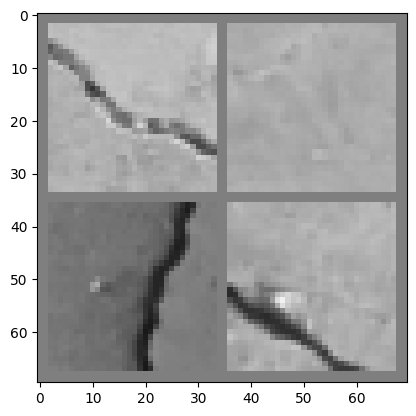

In [6]:
#Extract random training imges
dataiter = iter(trainloader)
images, labels = dataiter.__next__()
imshow(torchvision.utils.make_grid(images, nrow=2))

In [7]:
images.shape

torch.Size([4, 1, 32, 32])

In [8]:
images[0]

tensor([[[0.4824, 0.4353, 0.4588,  ..., 0.4588, 0.4588, 0.4588],
         [0.4824, 0.4588, 0.4431,  ..., 0.4667, 0.4667, 0.5059],
         [0.4980, 0.4745, 0.4824,  ..., 0.4980, 0.4667, 0.5608],
         ...,
         [0.4196, 0.4039, 0.3961,  ..., 0.3333, 0.3647, 0.4039],
         [0.4118, 0.4275, 0.4118,  ..., 0.3804, 0.3725, 0.3961],
         [0.3725, 0.4039, 0.4196,  ..., 0.4196, 0.3804, 0.3961]]])

In [9]:
images[0].shape

torch.Size([1, 32, 32])

Create custom model

In [10]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) #out: BS, 6, 30, 30
        self.pool = nn.MaxPool2d(2, 2)  #out: BS, 6, 15, 15
        self.conv2 = nn.Conv2d(6, 16, 3)  #out: BS, 16, 13, 13
        self.fc1 = nn.Linear(16 * 6 * 6, 128)  #out: after max pool BS, 16, 6, 6
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    #Create forward function
    def forward(self, x):
        x = self.conv1(x)  # out: BS, 6, 30, 30
        x = self.relu(x)   # #out: BS, 6, 15, 15
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)

        x = self.sigmoid(x)
        return x
    

Instantiate the model

In [11]:
model = BinaryClassification()
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.8)

Training loop

In [12]:
NUM_EPOCHS = 1
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        #Zero gradients
        optimizer.zero_grad()
        #forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.reshape(-1, 1).float())
        loss.backward()
        optimizer.step()
        if i % 5000 == 0:
            #print('Epoch: {}/{}, Step: {}/len(l), Loss: {:.3f}'.format(epoch, NUM_EPOCHS, i+1, len(trainloader), loss.item()))
            print(f'Epoch {epoch}/{NUM_EPOCHS}, Step {i+1}/{len(trainloader)},'
                  f'Loss: {loss.item():.4f}')

Epoch 0/1, Step 1/10000,Loss: 0.6931
Epoch 0/1, Step 5001/10000,Loss: 0.5883


inputs.shape

In [13]:
outputs

tensor([[0.5000],
        [0.9981],
        [0.5000],
        [0.5000]], grad_fn=<SigmoidBackward0>)

In [14]:
outputs.shape

torch.Size([4, 1])

In [15]:
labels

tensor([0, 1, 0, 0])

In [16]:
labels.shape

torch.Size([4])

Test loop

In [17]:
y_test = []
y_test_pred = []

for i, data in enumerate(testloader, 0):
    inputs, y_test_temp = data
    with torch.no_grad():
        y_test_pred_temp = model(inputs).round()

    y_test.extend(y_test_temp.numpy())
    y_test_pred.extend(y_test_pred_temp.numpy())
    

In [18]:
accuracy = accuracy_score(y_test, y_test_pred)
print('Accuracy Score: {:.2f}'.format(accuracy))

Accuracy Score: 0.97
